In [2]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
import copy
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
import time

In [3]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import plot_nmfs
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.network import load_model, train_network
from expbasics.biased_noisy_dataset import get_biased_loader
from expbasics.test_dataset import TestDataset

%reload_ext autoreload
%autoreload 2

In [4]:
BIAS = 0.95
LEARNING_RATE = 0.001
STRENGTH = 0.5
EPOCHS = 1
NUM_IT = 0
""" MODEL_NAME = to_name(BIAS, NUM_IT)
model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS, NUM_IT) """


' MODEL_NAME = to_name(BIAS, NUM_IT)\nmodel, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS, NUM_IT) '

{0: Counter({False: 238585, True: 7175}), 1: Counter({True: 238747, False: 7013})}
cpu
model_test_A_b0i92_0.pickle
EPOCH 1:


1152it [01:22, 14.02it/s, acc=97.9, batch=1100, epoch=1, loss=0.12]


loss epoch: 0.12269680269062519
best loss:  0.12269680269062519  last loss:  0.12269680269062519  best epoch:  model_0_0.92


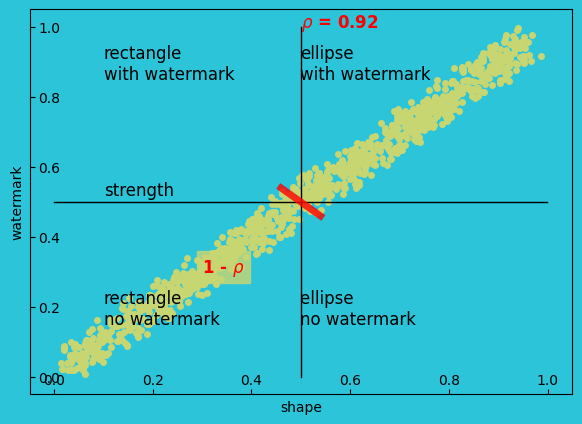

In [39]:
BIAS = 0.9
training_loaderA = get_biased_loader(BIAS, verbose=False)
modelA = train_network(
    training_loaderA,
    BIAS,
    STRENGTH,
    "model_test_A",
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    disable=False,
    seeded=True,
    num_it=NUM_IT
)

paramsA = [p.flatten() for p in modelA.parameters()]

In [46]:
BIAS = 0.9
start = time.time()
training_loaderB = get_biased_loader(BIAS, verbose=False)
modelB = train_network(
    training_loaderB,
    BIAS,
    STRENGTH,
    "model_test_B",
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    disable=False,
    seeded=True,
    num_it=NUM_IT,
)

end = time.time()
print(end - start)
paramsB = [p.flatten() for p in modelB.parameters()]

cpu
model_test_B_b0i9_0.pickle
EPOCH 1:


1152it [01:23, 13.74it/s, acc=98.8, batch=1100, epoch=1, loss=0.04]

loss epoch: 0.036650141859427096
best loss:  0.036650141859427096  last loss:  0.036650141859427096  best epoch:  model_0_0.9


In [13]:
paramsAx = torch.cat(paramsA)
paramsBx = torch.cat(paramsB)

torch.all(paramsAx == paramsBx)

tensor(False)

In [70]:
BIASES = list(np.round(np.linspace(0, 1, 26), 3))
ITERATIONS = range(10)  # range(4, 8)
# np.round(np.linspace(0.8, 1, 21), 3) # 101
count = 0

for bias in BIASES:
    for num_it in ITERATIONS:
        count += 1
count

260

[0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0]


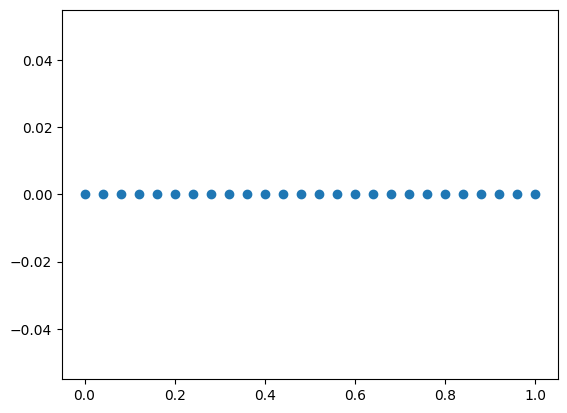

In [68]:
print(BIASES)
plt.scatter( BIASES, [0 for i in range(len(BIASES))],)

In [33]:
BIAS = 0.9

alltimes = []

startgen = time.time()
test_dataset = TestDataset(10000, bias=BIAS, im_dir="test_data")
endgen = time.time()
gent = endgen - startgen
alltimes.append(gent)
print(alltimes)

for i in range(10):
    start = time.time()
    test_dataset = TestDataset(10000, bias=BIAS, im_dir="test_data")
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
    test_model = train_network(
        test_loader,
        BIAS,
        STRENGTH,
        "model_testdata",
        epochs=1,
        learning_rate=LEARNING_RATE,
        disable=True,
        seeded=True,
        num_it=i,
    )
    end = time.time()
    mtime = end - start
    alltimes.append(mtime)
    print(mtime)

making new test dataset
[4.635369539260864]
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.78255295753479
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.436544418334961
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.6678099632263184
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.5231308937072754
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.3992207050323486
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.2916555404663086
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.742698907852173
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.697047710418701
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
3.637843132019043
EPOCH 1:
loss epoch: 0.0
best loss:

{0: Counter({True: 245760}), 1: Counter({True: 245760})}


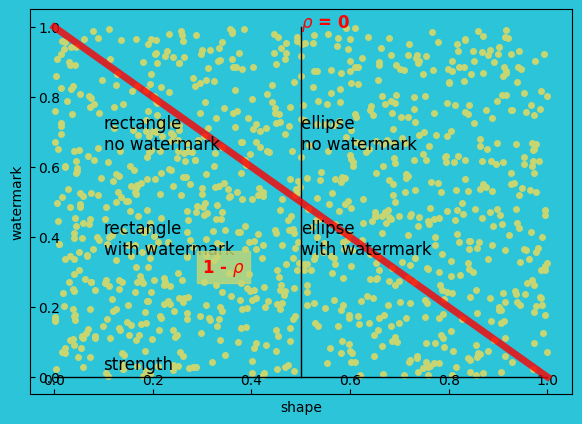

In [40]:

get_biased_loader(bias=0, strength=0, split=0.020347, verbose=True)

In [36]:
BIAS = 0.9

alltimes2 = []

for i in range(10):
    start = time.time()
    test_loader = get_biased_loader(bias=BIAS, split=0.020347, verbose=False)
    test_model = train_network(
        test_loader,
        BIAS,
        STRENGTH,
        "model_testdata",
        epochs=1,
        learning_rate=LEARNING_RATE,
        disable=True,
        seeded=True,
        num_it=i,
    )
    end = time.time()
    mtime = end - start
    alltimes2.append(mtime)
    print(mtime)

EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.611242055892944
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.559481143951416
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.638744831085205
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.388640642166138
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.324157953262329
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.288113355636597
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.401106595993042
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.479245901107788
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.9
5.386468887329102
EPOCH 1:
loss epoch: 0.0
best loss:  0.0  last loss:  0.0  best epoch:  model_0_0.

In [37]:
sum(alltimes2) / 10

5.47508671283722

In [54]:

startgen = time.time()
test_dataset = TestDataset(100000, bias=BIAS, im_dir="traindata")
endgen = time.time()
gent = endgen - startgen


start = time.time()
test_dataset = TestDataset(100000, bias=BIAS, im_dir="traindata")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
test_model = train_network(
    test_loader,
    BIAS,
    STRENGTH,
    "model_testdata",
    epochs=3,
    learning_rate=LEARNING_RATE,
    disable=False,
    seeded=True,
    num_it=5,
)
end = time.time()
mtime = end - start

print(gent, mtime)

making new test dataset
cpu
model_testdata_b0i9_5.pickle
EPOCH 1:


782it [00:48, 16.03it/s, acc=77, batch=700, epoch=1, loss=0.46]  


loss epoch: 0.4631557604670525
EPOCH 2:


782it [00:47, 16.34it/s, acc=98.1, batch=700, epoch=2, loss=0.07]


loss epoch: 0.06743543719872833
EPOCH 3:


782it [00:46, 16.79it/s, acc=98.1, batch=700, epoch=3, loss=0.06]

loss epoch: 0.058300915998406706
best loss:  0.058300915998406706  last loss:  0.058300915998406706  best epoch:  model_2_0.9
52.72283673286438 143.62530088424683


In [55]:
21 * 1.7


35.699999999999996

In [52]:
from expbasics.network import accuracy_per_class


tdataset = TestDataset(10000, bias=0.0,strength=0.0, im_dir="nowm")
tloader = DataLoader(tdataset, batch_size=128, shuffle=True)

accs = accuracy_per_class(test_model, tloader)

making new test dataset


In [53]:
accs

[52.96, 94.0, 73.4800033569336]

In [47]:
list(np.round(np.linspace(0, 1, 21), 3))

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]